In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!pip install tensorflow --upgrade
!pip install -q git+https://github.com/tensorflow/docs
!pip install git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 33.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [ ]:
cd /content/gdrive/MyDrive/KTH dataset


/content/gdrive/MyDrive/KTH dataset


In [ ]:
pwd

'/content/gdrive/MyDrive/KTH dataset'

In [ ]:
import os
import numpy as np
import pandas as pd

path = os.listdir('/content/gdrive/MyDrive/KTH dataset/dataset')

rooms = []
for item in path:
  #get all the file names
  all_rooms = os.listdir('/content/gdrive/MyDrive/KTH dataset/dataset' + '/' +item)

  #add them to list
  for room in all_rooms:
    rooms.append((item, str('/content/gdrive/MyDrive/KTH dataset/dataset' + '/' +item) + '/' + room))

# Build a dataframe
df = pd.DataFrame(data=rooms, columns=['tag','video_name'])
print(df.head())

            tag                                         video_name
0  handclapping  /content/gdrive/MyDrive/KTH dataset/dataset/ha...
1  handclapping  /content/gdrive/MyDrive/KTH dataset/dataset/ha...
2  handclapping  /content/gdrive/MyDrive/KTH dataset/dataset/ha...
3  handclapping  /content/gdrive/MyDrive/KTH dataset/dataset/ha...
4  handclapping  /content/gdrive/MyDrive/KTH dataset/dataset/ha...


In [ ]:
df.shape

(599, 2)

In [ ]:
df = df.loc[:,['video_name','tag']]
df
df.to_csv('/content/gdrive/MyDrive/KTH dataset/dataset.csv')
df = pd.read_csv("dataset.csv")

print(f"Total videos for training: {len(df)}")
df.sample(10)

Total videos for training: 599


,Unnamed: 0,video_name,tag
523,523,/content/gdrive/MyDrive/KTH dataset/dataset/jo...,jogging
260,260,/content/gdrive/MyDrive/KTH dataset/dataset/wa...,walking
145,145,/content/gdrive/MyDrive/KTH dataset/dataset/bo...,boxing
273,273,/content/gdrive/MyDrive/KTH dataset/dataset/wa...,walking
567,567,/content/gdrive/MyDrive/KTH dataset/dataset/jo...,jogging
185,185,/content/gdrive/MyDrive/KTH dataset/dataset/bo...,boxing
81,81,/content/gdrive/MyDrive/KTH dataset/dataset/ha...,handclapping
435,435,/content/gdrive/MyDrive/KTH dataset/dataset/ru...,running
581,581,/content/gdrive/MyDrive/KTH dataset/dataset/jo...,jogging
146,146,/content/gdrive/MyDrive/KTH dataset/dataset/bo...,boxing


In [ ]:
from tensorflow_docs.vis import embed
from imutils import paths
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 150

MAX_SEQ_LENGTH = 30
NUM_FEATURES = 2048

In [ ]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y,x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

#labels = ['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']

def load_video(path, max_frames=0):

  # Read the Video File using the VideoCapture object.
  cap = cv2.VideoCapture(path)

  # Declare a list to store video frames.
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)

       # Resize the Frame to fixed height and width.
      #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
      frame = frame[:, :, [2, 1, 0]]

      #normalize the resized frames by dividing it with 255 so that each pixel value then lies between 0 and 1
      normalized_frame = frame / 255

      # Append the normalized frame into the frames list
      frames.append(normalized_frame)

      if len(frames) == max_frames:
        break

  finally:
    cap.release()

  return np.array(frames)



In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(df["tag"])
)
print(label_processor.get_vocabulary())

labels = df["tag"].values
labels = label_processor(labels[..., None]).numpy()
labels
#df["labels"]=labels

['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking']


array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [ ]:

def build_feature_extractor():
  feature_extractor = keras.applications.InceptionV3(
  weights="imagenet",
  include_top=False,
  pooling="avg",
  input_shape=(IMG_SIZE, IMG_SIZE, 3)
  )
  preprocess_input = keras.applications.inception_v3.preprocess_input

  inputs = keras.Input((IMG_SIZE,  IMG_SIZE, 3))
  preprocessed = preprocess_input(inputs)

  outputs = feature_extractor(preprocessed)
  return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
def prepare_all_videos(df, root_dir):

  num_samples = len(df)
  #take all classlabels from train_df column named 'tag' and store in labels
  labels = df["tag"].values

  #convert classlabels to label encoding
  labels = label_processor(labels[..., None]).numpy()

  video_paths = df["video_name"].values.tolist()

  frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")


  for idx, path in enumerate(video_paths):
    sample = []
    frames = load_video(os.path.join(root_dir, path))
    #add a batch dimension
    frames = frames[None, ...]

    temp_frame_features = np.zeros(
          shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):#
      video_length = batch.shape[0]
      length = min(MAX_SEQ_LENGTH, video_length)
      for j in range(length):
        temp_frame_features[i, j, :]  = feature_extractor.predict(
              batch[None, j, :]
         )


    frame_features[idx,] = temp_frame_features.squeeze()
    #y.append(df.loc[df["video_name"] == os.path.join("dataset", path) , 'labels'])


  return frame_features, labels

data, labels = prepare_all_videos(df, "train")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 275ms/step


In [ ]:
#data_df = pd.DataFrame(data)
#labels_df = pd.DataFrame(labels)
print(f'frame features in data set{data.shape}')
print(f'labels in train set{labels.shape}')

frame features in data set(599, 30, 2048)
labels in train set(599, 1)


In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, shuffle = True, random_state = 23)


In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.layers import LSTM

def create_model():

  lstm_units = 360
  class_vocab = label_processor.get_vocabulary()


  model = Sequential()
  model.add(LSTM(lstm_units,input_shape=(MAX_SEQ_LENGTH, NUM_FEATURES)))

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(len(class_vocab), activation='softmax'))

  model.compile(
      loss="sparse_categorical_crossentropy", optimizer="RMSProp", metrics=["accuracy"]
    )
  model.summary()

  return model




In [ ]:
#Utility for running experiments.
def run_experiment():

  filepath = "/tmp/video_classifier"
  checkpoint = keras.callbacks.ModelCheckpoint(
      filepath, save_weights_only=True, save_best_only=True, verbose=1
  )

  seq_model = create_model()
  history = seq_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    epochs=150,
    batch_size=30,
    callbacks=[checkpoint]
  )

  seq_model.load_weights(filepath)
  _, accuracy = seq_model.evaluate(test_features, test_labels)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")

  return history, seq_model


_, sequence_model = run_experiment()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 360)               3468960   
                                                                 
 dense_2 (Dense)             (None, 1024)              369664    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 3844774 (14.67 MB)
Trainable params: 3844774 (14.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
13/13 [==============================] - ETA: 0s - loss: 1.9616 - accuracy: 0.1671
Epoch 1: val_loss improved from inf to 1.86420, sav

In [ ]:
import pickle

with open('model_pickle','wb') as f:
  pickle.dump(sequence_model, f)

In [ ]:


with open('model_pickle','rb') as f:
  mp = pickle.load(f)

In [ ]:
mp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 360)               3468960   
                                                                 
 dense_2 (Dense)             (None, 1024)              369664    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 3844774 (14.67 MB)
Trainable params: 3844774 (14.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from moviepy.editor import *
from collections import deque

def prepare_single_video(frames):
    frames = frames[None, ...]
    #frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        #frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("dataset", path))
    frame_features = prepare_single_video(frames)
    probabilities = mp.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
         print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
#def to_gif(images):
    # converted_images = images.astype(np.uint8)
    # imageio.mimsave("animation.gif", converted_images, fps=5)
    # return embed.embed_file("animation.gif")


test_video = np.random.choice(df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
#to_gif(test_frames[:MAX_SEQ_LENGTH])
# Play Video File in the Notebook
VideoFileClip(test_video).ipython_display(width = 300)

Test video path: /content/gdrive/MyDrive/KTH dataset/dataset/jogging/person10_jogging_d4_uncomp.avi
1/1 [==============================] - 0s 499ms/step
  running: 53.30%
  jogging: 43.79%
  walking:  2.76%
  handwaving:  0.07%
  handclapping:  0.04%
  boxing:  0.04%
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
# from sklearn.preprocessing import LabelEncoder

# class_vocab = label_processor.get_vocabulary()
# label_encoder = LabelEncoder()
# label_encoder.fit(class_vocab)
# labels_data = label_encoder.transform(class_vocab)



# test_video = np.random.choice(df["video_name"].values.tolist())
# print(f"Test video path: {test_video}")
# test_frames = sequence_prediction(test_video)

test_prediction = mp.predict(test_features)

4/4 [==============================] - 1s 229ms/step


In [ ]:
test_prediction

array([[3.43673587e-01, 1.57861829e-01, 4.96931136e-01, 4.73531691e-04,
        6.15197758e-04, 4.44682577e-04],
       [3.67792174e-02, 1.37599498e-01, 8.24418843e-01, 4.40930628e-04,
        3.46382643e-04, 4.15033894e-04],
       [7.28247091e-02, 1.09784760e-01, 8.16794872e-01, 1.62755052e-04,
        1.98464957e-04, 2.34502761e-04],
       [7.89367139e-01, 9.41077620e-02, 1.15410298e-01, 2.90594850e-04,
        5.21409500e-04, 3.02748755e-04],
       [4.19451259e-02, 3.12538654e-01, 6.44943357e-01, 1.63471181e-04,
        2.67575582e-04, 1.41832803e-04],
       [1.61284895e-03, 9.32261765e-01, 6.49208277e-02, 7.47216109e-04,
        1.83670840e-04, 2.73499929e-04],
       [9.27562118e-02, 4.77055460e-02, 8.59200776e-01, 1.09966619e-04,
        1.31333698e-04, 9.61503247e-05],
       [8.94441485e-01, 4.38074097e-02, 6.12672530e-02, 1.12588838e-04,
        2.66438146e-04, 1.04764244e-04],
       [8.15044865e-02, 7.52516925e-01, 1.63819239e-01, 1.08930795e-03,
        6.05351757e-04, 

In [ ]:
test_prediction[1]

array([3.6779217e-02, 1.3759950e-01, 8.2441884e-01, 4.4093063e-04,
       3.4638264e-04, 4.1503389e-04], dtype=float32)

In [ ]:
np.argmax(test_prediction[1])

2

In [ ]:
predicted_labels = [np.argmax(i) for i in test_prediction]
predicted_labels[:5]

[2, 2, 2, 0, 2]

In [ ]:
actual_labels=test_labels.flatten()


In [ ]:
actual_labels[:5]

array([0, 2, 2, 0, 2])

In [ ]:
cm = tf.math.confusion_matrix(labels=actual_labels, predictions=predicted_labels)
cm

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[18,  1,  4,  0,  1,  0],
       [ 1, 14,  3,  0,  0,  0],
       [ 5,  2, 14,  0,  0,  0],
       [ 0,  0,  0,  8,  4,  6],
       [ 0,  0,  0,  5, 13,  4],
       [ 0,  0,  0,  1,  1, 15]], dtype=int32)>

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report

import seaborn as sns

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap = 'crest')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

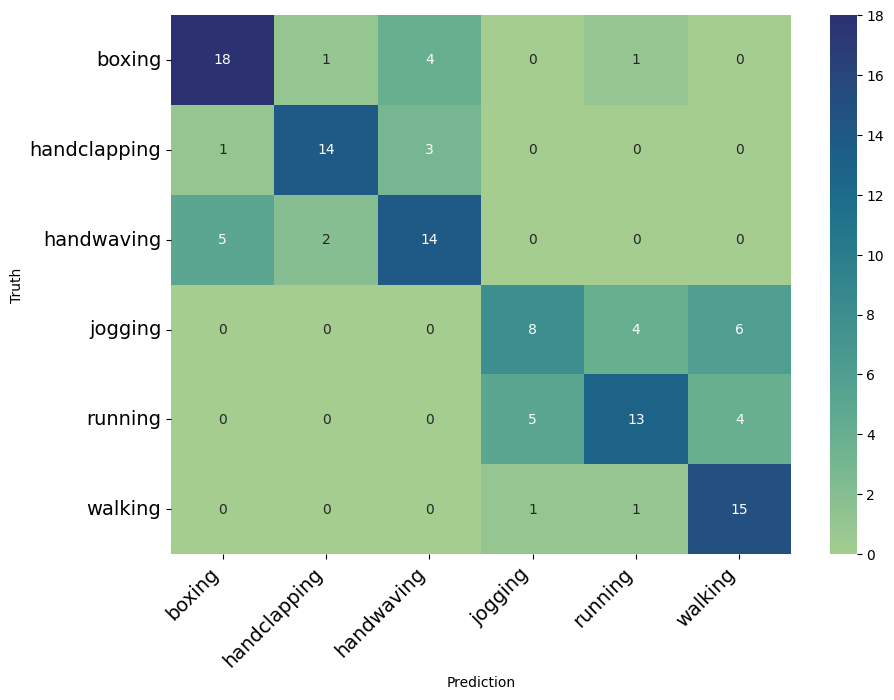

In [ ]:
class_vocab = label_processor.get_vocabulary()
cm = confusion_matrix(actual_labels,predicted_labels)
print_confusion_matrix(cm,class_vocab)

In [ ]:
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        24
           1       0.82      0.78      0.80        18
           2       0.67      0.67      0.67        21
           3       0.57      0.44      0.50        18
           4       0.68      0.59      0.63        22
           5       0.60      0.88      0.71        17

    accuracy                           0.68       120
   macro avg       0.68      0.69      0.68       120
weighted avg       0.69      0.68      0.68       120

